# Occlusion for localization

In [16]:
import torch

import numpy as np
import matplotlib.pyplot as plt

import glob
import cv2

from captum.attr import Occlusion

# Change sys path to import from parent directory
import sys
sys.path.append('../')

from utils.datasets import ImageDataset

## Load model and dataset

In [17]:
# Download the model using torch hub
model = torch.hub.load('conorosully/XAI-for-CV-models', 'car_single_room')

# Set the model to evaluation mode
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)
model.eval()

Using cache found in /Users/conorosullivan/.cache/torch/hub/conorosully_XAI-for-CV-models_main


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=50176, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [18]:
base_path = "../../data/auto_car/single_room"
val_paths = glob.glob(base_path + "/val/*.jpg")

# Load the validation data
val_data = ImageDataset(val_paths,num_classes=1)
print(f"Validation data: {val_data.__len__()}")

Validation data: 300


Figure saved to /Users/conorosullivan/Documents/XAI/occlusion_prediction.pdf


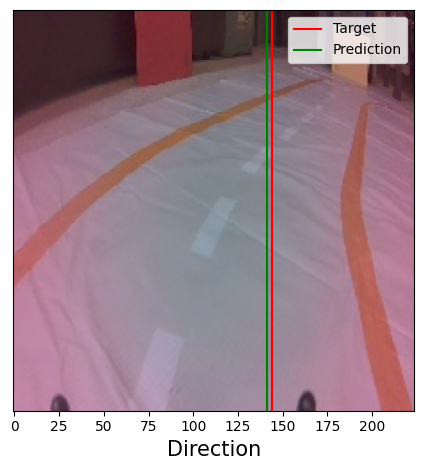

In [19]:
image, target = val_data.__getitem__(1)
image = image.to(device)
image = image.unsqueeze(0) # Add batch dimension

# Get prediction
pred = model(image)

# Format prediction, target and image
pred = pred.item()
target = target.item()
display_image = image.cpu().detach().squeeze(0).permute(1,2,0).numpy()
display_image =display_image*255
display_image = display_image.astype(np.uint8)

# Plot image
plt.imshow(display_image)
plt.axvline(x=target, color='r',label='Target')
plt.axvline(x=pred, color='g',label='Prediction')
plt.legend()

plt.yticks([])

# Set x label
plt.xlabel('Direction',size=15)

## Occlusion maps

In [20]:
# Define the occlusion object
occlusion = Occlusion(model)

# Apply occlusion
attributions = occlusion.attribute(image,
                                   strides=16,
                                   sliding_window_shapes=(3, 32, 32))

# Convert to numpy and plot the saliency map
saliency_map = attributions.squeeze().cpu().detach().numpy()

print(saliency_map.shape) # (3, 224, 224)

(3, 224, 224)


In [21]:
saliency_map = saliency_map[0] # all channels are the same

print("Min:", saliency_map.min()) # -53.7
print("Max:", saliency_map.max()) # 44.3

Min: -53.70477
Max: 44.32772


Figure saved to /Users/conorosullivan/Documents/XAI/occlusion_saliency_map.pdf


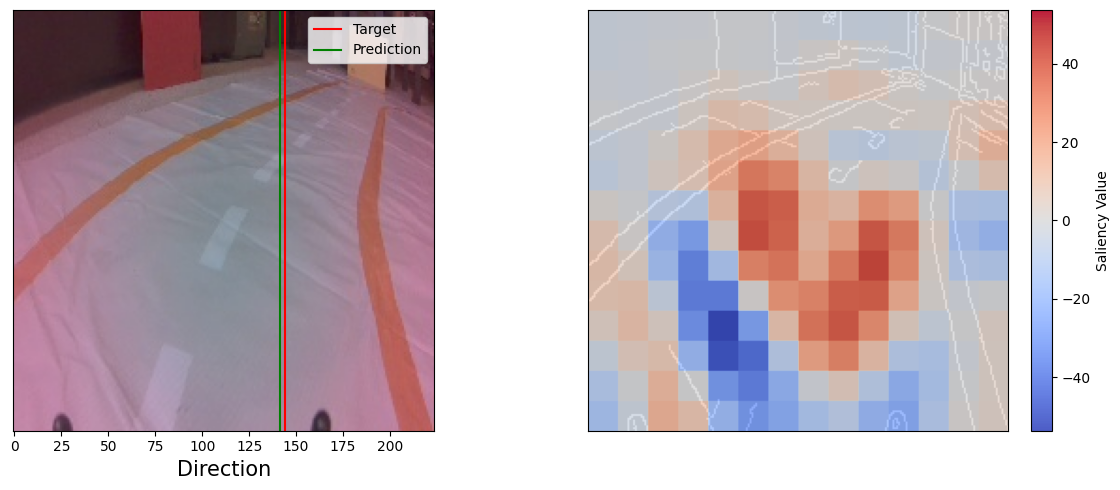

In [22]:
# Create edge image
grey_image = cv2.cvtColor(display_image, cv2.COLOR_RGB2GRAY)
edge_image = cv2.Canny(grey_image, 50, 100)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Display image and prediction
ax[0].imshow(display_image)
ax[0].axvline(x=target, color='r',label='Target')
ax[0].axvline(x=pred, color='g',label='Prediction')
ax[0].legend()

ax[0].set_yticks([])
ax[0].set_xlabel('Direction',size=15)

# Display saliency map
ax[1].imshow(edge_image , cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])

# Normalize saliency map values
abs_max = np.max(np.abs(saliency_map))

# Overlay saliency map with color bar
saliency_plot = ax[1].imshow(saliency_map,
                             alpha=0.9,
                             cmap='coolwarm',
                             vmin=-abs_max,
                             vmax=abs_max)

# Create colorbar
cbar = fig.colorbar(saliency_plot, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label("Saliency Value")

## Alternatives to the default color map

Figure saved to /Users/conorosullivan/Documents/XAI/occlusion_saliency_map_percentage.pdf


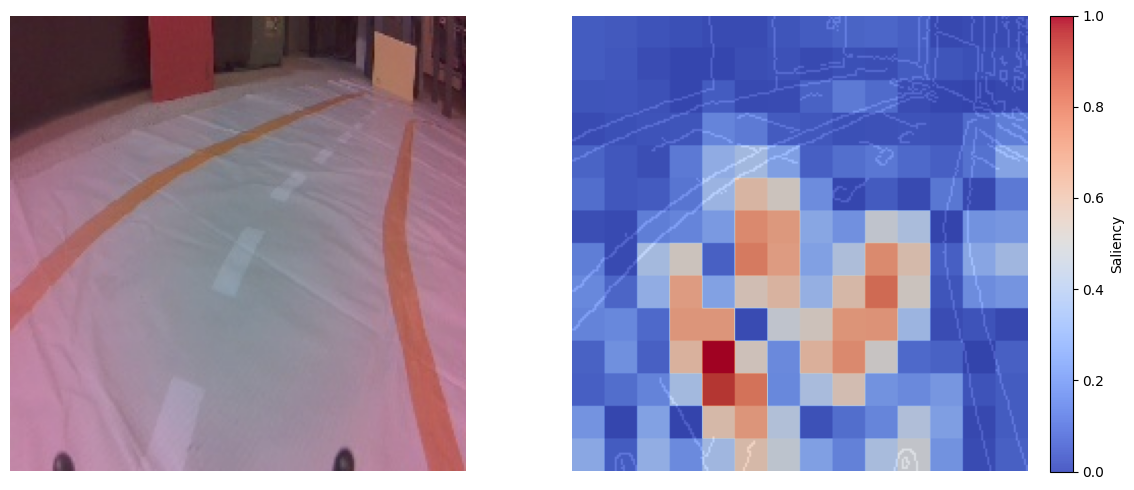

In [23]:
# Percentage of occlusion
per_saliency_map = np.abs(saliency_map) / abs_max

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(display_image)

# Overlay saliency map with color bar
ax[1].imshow(edge_image , cmap='gray')
saliency_plot = ax[1].imshow(per_saliency_map,
                             alpha=0.9,
                             cmap='coolwarm',
                             vmin=0,
                             vmax=1)

# Create colorbar
cbar = fig.colorbar(saliency_plot, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label("Saliency")

for a in ax:
    a.axis('off')

Figure saved to /Users/conorosullivan/Documents/XAI/occlusion_channels.pdf


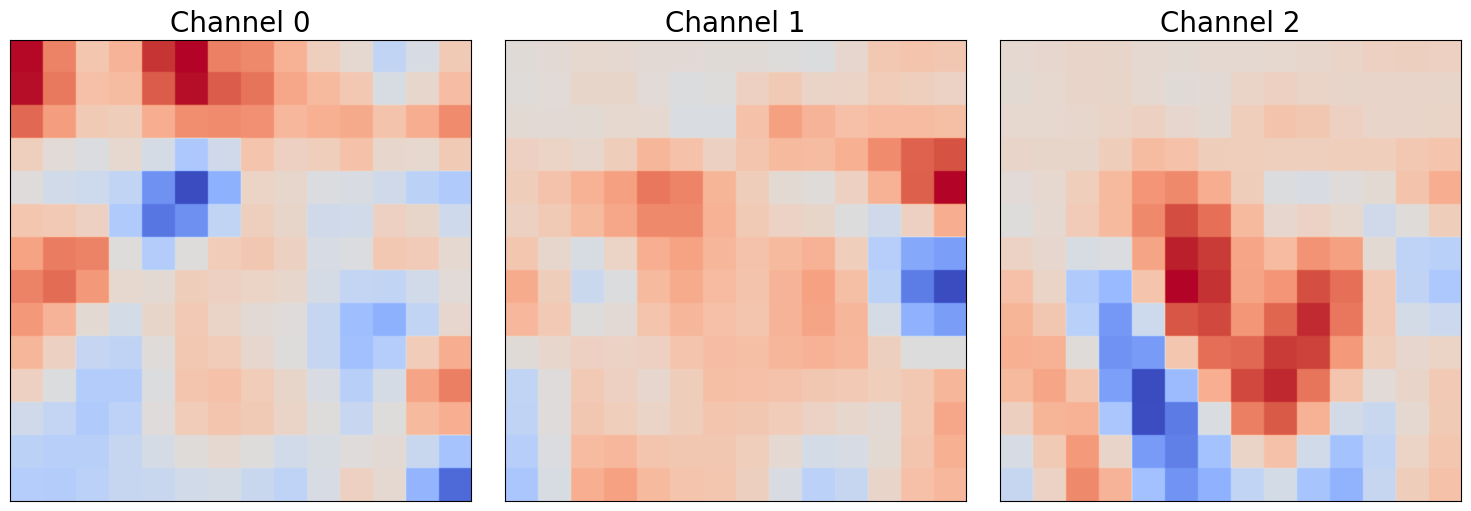

In [24]:
# Calculate for individual channels
attributions = occlusion.attribute(image,
                                   strides=(1, 16, 16),
                                   sliding_window_shapes=(1, 32, 32))

saliency_map = attributions.squeeze().cpu().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(saliency_map[i], cmap='coolwarm')
    ax[i].set_title(f"Channel {i}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

tensor([[[[0.5587]],

         [[0.4422]],

         [[0.4936]]]], device='mps:0')
Figure saved to /Users/conorosullivan/Documents/XAI/occlusion_mean_baseline.pdf


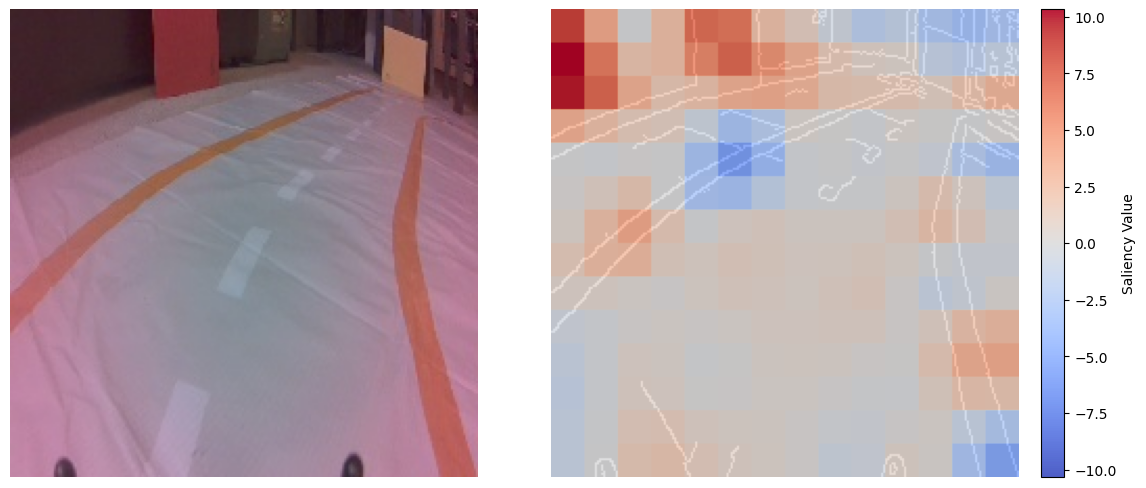

In [25]:
# Get mean of each channel
mean_baseline = torch.mean(image, dim=(2, 3), keepdim=True)
print(mean_baseline)

# Apply Occlusion
attributions = occlusion.attribute(image,
                                   strides=16,
                                   sliding_window_shapes=(3, 32, 32),
                                   baselines=mean_baseline)

# Convert to numpy and plot the saliency map
saliency_map = attributions.squeeze().cpu().detach().numpy()
saliency_map = saliency_map[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(display_image)
ax[1].imshow(edge_image , cmap='gray')

# Normalize saliency map values
abs_max = np.max(np.abs(saliency_map))

# Overlay saliency map with color bar
saliency_plot = ax[1].imshow(saliency_map,
                             alpha=0.9,
                             cmap='coolwarm',
                             vmin=-abs_max,
                             vmax=abs_max)

# Create colorbar
cbar = fig.colorbar(saliency_plot, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label("Saliency Value")

for a in ax:
    a.axis('off')